This tutorial demonstrates a basic usage of the image formation pipeline in `cryojax`.

It will demonstrate almost all of the modeling components that can be used when simulating a single image. This includes models for the instrument opticxs, electron dose rate, detector, and solvent. These models are all a work in progress.

In [1]:
# Jax imports
import jax

In [2]:
# Plotting imports and function definitions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(image, fig, ax, cmap="gray", label=None, **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

In [4]:
# CryoJAX imports
import cryojax.simulator as cxs

/mnt/home/gwoollard/software/mambaforge/envs/cryojax/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First we must read in our 3D scattering potential into a given voxel-based representation of the `potential`. Here, this is the `FourierVoxelGrid`. Then, we choose an integration method onto the exit plane.  Here, we use the fourier-slice projection theorem with the `FourierSliceExtract` integrator. In general, the `integrator` will depend on the scattering potential representation.

In [131]:
from cryojax.data import read_array_with_spacing_from_mrc


# Scattering potential stored in MRC format
filename = "./data/ribosome_4ug0_scattering_potential_from_cistem.mrc"
# Read template into a FourierVoxelGridPotential and choose an integrator
real_voxel_grid, voxel_size = read_array_with_spacing_from_mrc(filename)
potential = cxs.FourierVoxelGridPotential.from_real_voxel_grid(
    real_voxel_grid, voxel_size, pad_scale=2
)
integrator = cxs.FourierSliceExtract(interpolation_order=1)

In [132]:
potential.fourier_voxel_grid.shape

(160, 160, 160)

In [169]:
import jax.numpy as jnp

from cryojax.image import ifftn


potential_real = ifftn(jnp.fft.ifftshift(potential.fourier_voxel_grid)).real

plt.imshow(potential_real.sum(0))

AttributeError: 'RealVoxelGridPotential' object has no attribute 'fourier_voxel_grid'

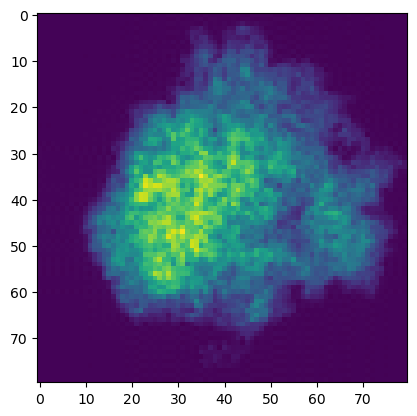

In [292]:
potential = cxs.RealVoxelGridPotential.from_real_voxel_grid(
    real_voxel_grid,
    voxel_size,
)
image = potential.real_voxel_grid.sum(0)
plt.imshow(image)

# multislice
* init plane wave
* take slice in real space potential
    * make tn object
* multiply plane wave and tn in real space
* take FT
* multiply by fresnen prop
* go back to real space

In [388]:
real_slices = potential_real.swapaxes(0, 2).swapaxes(0, 1)  # z-axis is the first axis
real_slices = potential.real_voxel_grid.swapaxes(0, 2).swapaxes(
    0, 1
)  # z-axis is the first axis


shape = real_slices.shape[1:]
plane_wave_n = jnp.ones(shape, dtype=jnp.complex64)

n_voxel_per_slice = 10
real_slices = real_slices.reshape(-1, n_voxel_per_slice, *shape).sum(1)


sigma = 1
transmission = jnp.exp(1j * sigma * real_slices)
delta_z = n_voxel_per_slice * voxel_size
voxel_size = 1
config = cxs.ImageConfig(shape=shape, pixel_size=voxel_size)
kx, ky = config.wrapped_coordinate_grid_in_angstroms.array.T
k2 = jnp.hypot(kx, ky) ** 2
lam = 0.03 / 1000  # 3 pm
fresnel_propagator = jnp.exp(-1j * jnp.pi * lam * k2 * delta_z)

plane_wave_ns = jnp.zeros((len(real_slices), *shape), dtype=jnp.complex64)
for n in range(len(transmission)):
    tn = transmission[n]
    t_psi_f = jnp.fft.fftn(tn * plane_wave_n)
    t_psi_f_shift = jnp.fft.fftshift(t_psi_f)
    plane_wave_ns = plane_wave_ns.at[n].set(
        jnp.fft.ifftn(t_psi_f_shift * fresnel_propagator)
    )

In [389]:
len(real_slices)

8

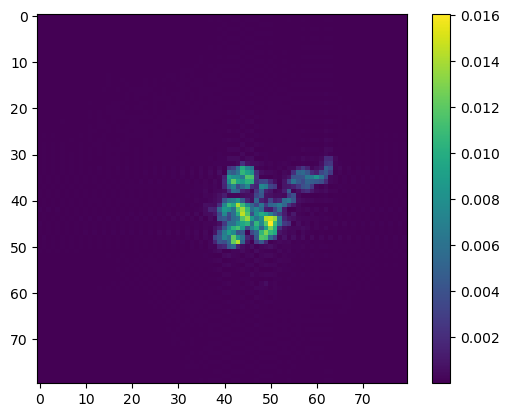

In [390]:
plt.imshow(jnp.abs(real_slices[0]))
plt.colorbar()

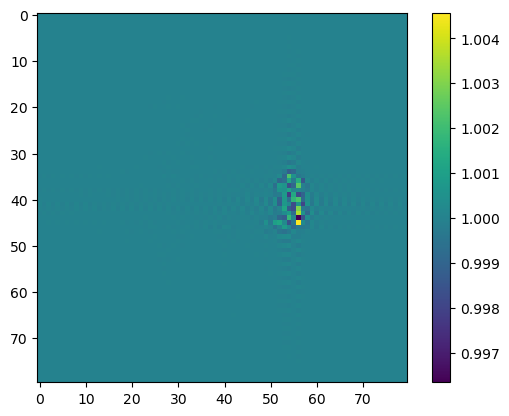

In [394]:
plt.imshow(jnp.abs(plane_wave_ns[-1]))
plt.colorbar()

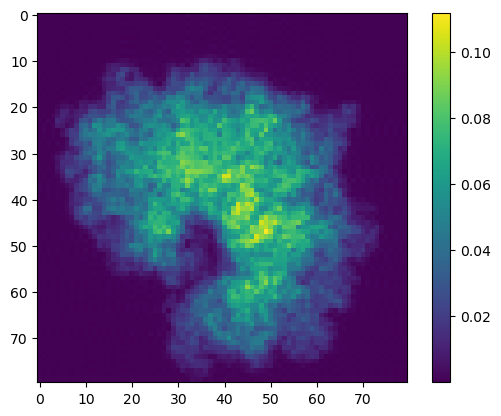

In [392]:
plt.imshow(jnp.abs(real_slices.sum(0)))
plt.colorbar()

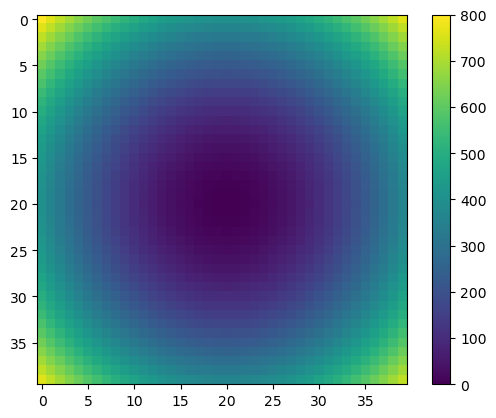

In [393]:
plt.imshow(k2[20:-20, 20:-20])
plt.colorbar()

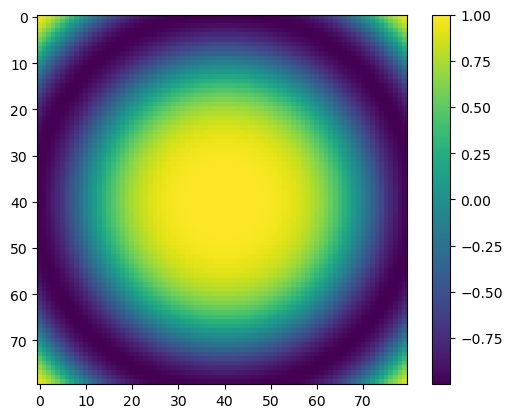

In [386]:
plt.imshow(fresnel_propagator.real)
plt.colorbar()

In [387]:
potential.real_voxel_grid.shape

(80, 80, 80)

Next, we must instantiate the biological specimen. A `Specimen` takes in the `potential`, `integrator`, and also a `pose`. Here, we represent the `pose` with an `EulerAnglePose`.

In [6]:
# Instantiate the pose and build the specimen
pose = cxs.EulerAnglePose(
    offset_x_in_angstroms=-2.0,
    offset_y_in_angstroms=5.0,
    view_phi=20.0,
    view_theta=80.0,
    view_psi=-10.0,
)
specimen = cxs.Specimen(potential, integrator, pose)

Now, it's time to configure the imaging instrument. We can include models for the instrument optics, the electron dose, and the detector. Here, we create an instrument just with an optics model, and one that also includes a a detector model. We will see in a few lines why we have done this.

In [7]:
# Initialize the instrument
voltage_in_kilovolts = 300.0
dose = cxs.ElectronDose(electrons_per_angstrom_squared=100.0)
optics = cxs.WeakPhaseOptics(
    ctf=cxs.CTF(
        defocus_u_in_angstroms=10000.0,
        defocus_v_in_angstroms=9000.0,
        astigmatism_angle=20.0,
        amplitude_contrast_ratio=0.07,
    )
)
detector = cxs.PoissonDetector(dqe=cxs.IdealDQE(fraction_detected_electrons=1.0))
instrument_with_dose = cxs.Instrument(voltage_in_kilovolts, dose=dose)
instrument_with_optics = cxs.Instrument(voltage_in_kilovolts, dose=dose, optics=optics)
instrument_with_detector = cxs.Instrument(
    voltage_in_kilovolts, dose=dose, optics=optics, detector=detector
)

Optionally, we can choose a model for the solvent. Here, we model the ice as gaussian colored noise with `GaussianIce` and choose an analytical model for the power spectrum taken from the `cryojax.image.operators` module. Here, we choose the `FourierExp2D` envelope, whose abstract base class is an `AbstractFourierOperator`.

In [8]:
from cryojax.image.operators import FourierExp2D


# Then, choose a model for the solvent. The amplitude is the
# (squared) characteristic phase shift of the ice phase shifts, and the length_scale is
# their characteristic length scale.
solvent = cxs.GaussianIce(
    variance=FourierExp2D(amplitude=0.005**2, length_scale=2.0 * potential.voxel_size)
)

Finally, we create an `ImageConfig` and initialize our `ImagePipeline`. In this example, we would like to simulate images at each stage of the image formation process. This is controlled by the modeling complexity in the `Instrument`, which here has three levels.

**1. If the `Instrument` just has an accelerating voltage and a dose:** In this case, the returned "image" is the phase shifts in the exit plane.

**2. If the `Instrument` also has an optics model:** The returned "image" here is the squared wavefunction in the detector plane.

**3. If the `Instrument` also has a detector model:** Last, the returned "image" is the detector readout.

In [9]:
# Create the image configuration
config = cxs.ImageConfig(
    shape=(80, 80), pixel_size=potential.voxel_size, padded_shape=potential.shape[:2]
)
# ... now, build the image formation models
scattering_pipeline = cxs.ImagePipeline(
    config=config, specimen=specimen, instrument=instrument_with_dose, solvent=solvent
)
optics_pipeline = cxs.ImagePipeline(
    config=config,
    specimen=specimen,
    instrument=instrument_with_optics,
    solvent=solvent,
)
detector_pipeline = cxs.ImagePipeline(
    config=config,
    specimen=specimen,
    instrument=instrument_with_detector,
    solvent=solvent,
)

Before proceeding, we must create jit-compiled functions that simulate our images.

In [10]:
import equinox as eqx
from jaxtyping import PRNGKeyArray


@eqx.filter_jit
def compute_image(pipeline: cxs.ImagePipeline):
    """Simulate an image without noise from a `pipeline`."""
    return pipeline.render()


@eqx.filter_jit
def compute_noisy_image(pipeline: cxs.ImagePipeline, key: PRNGKeyArray):
    """Simulate an image with noise from a `pipeline`."""
    return pipeline.sample(key)

**What's with the eqx.filter_jit?**

This is an example of an equinox *filtered transformation*. In this case, the `eqx.filter_jit` decorator is a lightweight wrapper around `jax.jit` that treats all of the `pipeline`'s JAX arrays as traced at compile time, and all of its non-JAX arrays as static. Alternatively, we could have used the usual `jax.jit` decorator and explicitly passed traced and static pytrees to our function. It is completely optional to use `equinox` decorators.

Filtered transformations are a cornerstone to `equinox` and it is highly recommended to learn about them. See [here](https://docs.kidger.site/equinox/all-of-equinox/#2-filtering) in the equinox documentation for an introduction.

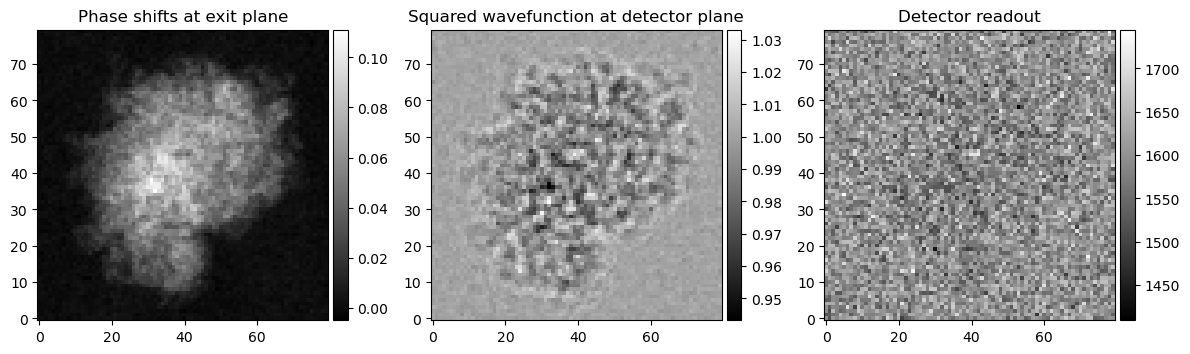

In [11]:
# Simulate each image, drawing from the stochastic parts of the model
key = jax.random.PRNGKey(0)
fig, axes = plt.subplots(ncols=3, figsize=(12, 6))
ax1, ax2, ax3 = axes
im1 = plot_image(
    compute_noisy_image(scattering_pipeline, key),
    fig,
    ax1,
    label="Phase shifts at exit plane",
)
im2 = plot_image(
    compute_noisy_image(optics_pipeline, key),
    fig,
    ax2,
    label="Squared wavefunction at detector plane",
)
im3 = plot_image(
    compute_noisy_image(detector_pipeline, key), fig, ax3, label="Detector readout"
)
plt.tight_layout()

What if we did not want to include noise in the simulation? In this case, the three outputs are

**1. If there the `Instrument` just has an accelerating voltage and a dose:** The returned "image" is the phase shifts in the exit plane including stochasticity, which here we use in the `solvent` model.

**2. If the `Instrument` also has an optics model:** Again, the returned "image" is the squared wavefunction in the detector plane.

**3. If the `Instrument` also has a detector model:** Now, the returned "image" is the expected number of electron counts for each pixel. This is nothing but the poisson rate.

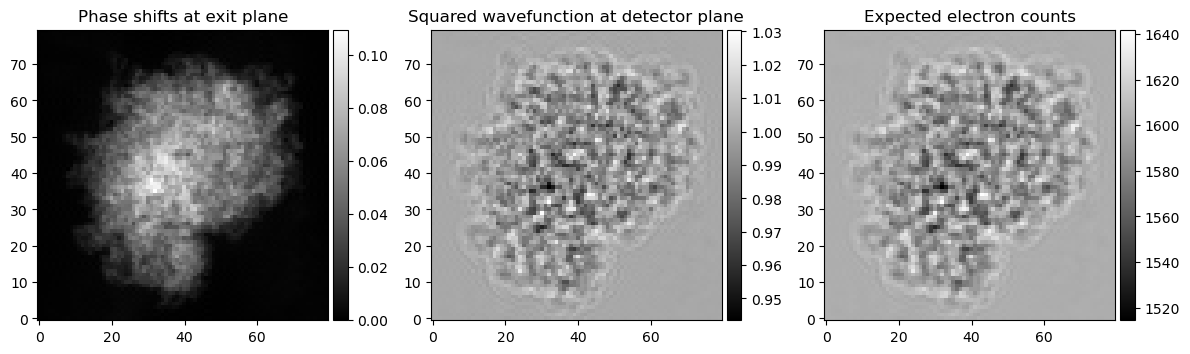

In [12]:
# Simulate each image without stochasticity
key = jax.random.PRNGKey(0)
fig, axes = plt.subplots(ncols=3, figsize=(12, 6))
ax1, ax2, ax3 = axes
im1 = plot_image(
    compute_image(scattering_pipeline),
    fig,
    ax1,
    label="Phase shifts at exit plane",
)
im2 = plot_image(
    compute_image(optics_pipeline),
    fig,
    ax2,
    label="Squared wavefunction at detector plane",
)
im3 = plot_image(
    compute_image(detector_pipeline), fig, ax3, label="Expected electron counts"
)
plt.tight_layout()